In [145]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [146]:
#check for GPU availability
torch.cuda.is_available()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define Functions

## 1) function to preprocess (1-hot encode) MONK data

In [147]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

## Function to plot training curves

In [148]:
def plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams):
    '''
    Plot training and test curves for loss and accuracy.

    Parameters:
    - epoch (int): The number of epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_accuracies (list): List of training accuracies for each epoch.
    - test_accuracies (list): List of test accuracies for each epoch.
    - hyperparams (list): List of hyperparameters [hidden_units, lr, alpha, batch_size, lambda].

    Returns:
    None
    '''
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Batch Size={hyperparams[3]}, Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}')
    # Loss plots
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epoch + 2), train_losses, label='Training Loss', color = 'red')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plots
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epoch + 2), train_accuracies, label='Training Accuracy', color='red')
    plt.plot(range(1, epoch + 2), test_accuracies, label='Test Accuracy', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Define the model

In [149]:
# Define the classifier

class MonkClassifier(nn.Module):
    def __init__(self, hidden_size, input_size=17, output_size=1, weight_init_constant=0.01):
        super(MonkClassifier, self).__init__()

        # Custom weight initialization function
        #def init_weights(m):
        #    if type(m) == nn.Linear:
        #        if hasattr(m, 'weight') and m.weight is not None:
        #            init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #            if m.bias is not None:
        #               init.constant_(m.bias, 0)

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

        # Apply custom weight initialization to linear layers
        #self.apply(init_weights)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

In [150]:
def training_model(x_train, y_train, x_test, y_test, hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs=1000, plot_curves=False):
    '''
    Train a Monk classifier model.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test (or Validation) input data.
    - y_test (torch.Tensor): Test (or Validation) target data.
    - hidden_size (int): Size of the hidden layer in the model.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - batch_size (int): Batch size for training and testing.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - num_epochs (int): Maximum number of training epochs (default: 1000).
    - plot_curves (bool): Whether to plot training curves (default: False).

    Returns:
    - epoch (int): Number of epochs completed.
    - train_loss (float): Final training loss.
    - test_loss (float): Final test (or validation) loss.
    - train_accuracy (float): Final training accuracy.
    - test_accuracy (float): Final test (or validation) accuracy.
    '''

    # Create an instance of the model
    model = MonkClassifier(hidden_size)
    #model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # parameters to stop at training convergence
    prev_loss = float('inf')
    #prev_accuracy = 0
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate accuracy
        predicted_labels = torch.round(y_pred)
        correct_predictions = (predicted_labels == y_train).sum().item()
        total_samples = y_train.size(0)
        accuracy = correct_predictions / total_samples

        train_losses.append(train_loss.item())
        train_accuracies.append(accuracy)

        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        # Evaluation on the test/validation set
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test accuracy
            predicted_test_labels = torch.round(test_outputs)
            correct_test_predictions = (predicted_test_labels == y_test).sum().item()
            total_test_samples = y_test.size(0)
            test_accuracy = correct_test_predictions / total_test_samples

            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss.item())

        print(f'Training - Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, '
            f'Accuracy: {accuracy:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} Accuracy: {test_accuracy:.4f} ', end='\r')

        # Check for convergence
        if abs(prev_loss - train_loss.item()) < 1e-5:
            patience_counter += 1
        else:
            patience_counter = 0

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break
        prev_loss = train_loss.item()

    print(f'\n N. Epochs = {epoch+1} - Loss (train | test)= ({train_loss.item():.4} | {test_loss.item():.4}) - Accuracy (train | test) = ({accuracy} | {test_accuracy})')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, num_epochs]
        plot_training_curves(epoch, train_losses, test_losses, train_accuracies, test_accuracies, hyperparams)

    return epoch+1, train_loss.item(), test_loss.item(), accuracy, test_accuracy

In [151]:
def perform_grid_search_kfold(hidden_sizes, learning_rates, momentums, batch_sizes, reg_coeffs, k_folds, x, y, plot_curves=False, num_epochs=1000):
    '''
    Perform grid search with k-fold cross-validation for Monk classifier hyperparameters.

    Parameters:
    - hidden_sizes (list): List of hidden layer sizes to explore.
    - learning_rates (list): List of learning rates to explore.
    - momentums (list): List of momentum values to explore.
    - batch_sizes (list): List of batch sizes to explore.
    - reg_coeffs (list): List of regularization coefficients to explore.
    - k_folds (int): Number of folds for cross-validation.
    - x (torch.Tensor): Input data.
    - y (torch.Tensor): Target data.
    - plot_curves (bool): Whether to plot training curves for each hyperparameter combination (default: False).

    Returns:
    - best_hyperparams (list): List of best hyperparameters based on highest average validation accuracy.
    '''

    best_acc = 0
    best_hyperparams = []

    for hidden_size, learning_rate, momentum, bs, reg_coeff in product(hidden_sizes,learning_rates,momentums,batch_sizes, reg_coeffs):
        print(f'hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}')

        kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and accuracies for each epoch
        train_losses, val_losses, train_acc, val_acc = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):
            #print(f"\nFold {fold + 1}/{k_folds}")

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            max_epoch, average_loss, average_val_loss, average_accuracy, average_val_accuracy = training_model(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                hidden_size=hidden_size, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, plot_curves=plot_curves, num_epochs=num_epochs)

            train_losses.append(average_loss)
            val_losses.append(average_val_loss)
            train_acc.append(average_accuracy)
            val_acc.append(average_val_accuracy)

        print(f'Final Results: hidden_size={hidden_size}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_acc = {np.mean(train_acc):.4} +- {np.std(train_acc):.4} | '
            f'val_acc = {np.mean(val_acc):.4} +- {np.std(val_acc):.4}')

        if np.mean(val_acc) >= best_acc:
            best_acc = np.mean(val_acc)
            best_hyperparams = [hidden_size, learning_rate, momentum, bs, reg_coeff]

    print(best_hyperparams)
    return best_hyperparams

In [162]:
def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         hidden_size,learning_rate, momentum,
                                         bs, reg_coeff, num_epochs=1000,
                                         plot_curves=False, N = 5):
    '''
    train the model N times with different weight initializations,
    to estimate the model performances with mean and variance
    '''
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    for i in range (0,N):
        _, train_loss, test_loss, train_acc, test_acc = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        hidden_size,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        plot_curves=plot_curves,
                        num_epochs=num_epochs)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Train Loss: {np.mean(train_losses):.4} +- {np.std(train_losses):.4}')
    print(f'Test Loss: {np.mean(test_losses):.4} +- {np.std(test_losses):.4}')
    print(f'Train Acc: {np.mean(train_accs)*100:.4} +- {np.std(train_accs)*100:.4} %')
    print(f'Test Acc: {np.mean(test_accs)*100:.4} +- {np.std(test_accs)*100:.4} %')


# Monk 1

In [153]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])


## Perform Model Selection using a grid serch with k-fold cross validation

inizialmente modificare gli iperparametri ad occhio per avere un'idea di cosa succede,
poi fare una grid search più fine 

In [154]:
hidden_sizes = [5]
learning_rates = [0.01]
momentums = [0.9]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.9; batch size = 4; lambda = 0


Training - Epoch [272/1000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [272/1000], Loss: 0.0073 Accuracy: 1.0000 
 N. Epochs = 272 - Loss (train | test)= (0.00107 | 0.00735) - Accuracy (train | test) = (1.0 | 1.0)


KeyboardInterrupt: 

## Train the model (with best hyperparameters) using different weights initiaizatons
in order to estimate a mean and variance for the performance

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [281/1000], Loss: 0.0011, Accuracy: 1.0000 | Test - Epoch [281/1000], Loss: 0.0033 Accuracy: 1.0000 
 N. Epochs = 281 - Loss (train | test)= (0.001126 | 0.003347) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [301/1000], Loss: 0.0654, Accuracy: 0.9355 | Test - Epoch [301/1000], Loss: 0.0845 Accuracy: 0.9167 
 N. Epochs = 301 - Loss (train | test)= (0.06545 | 0.08447) - Accuracy (train | test) = (0.9354838709677419 | 0.9166666666666666)
Training - Epoch [301/1000], Loss: 0.0012, Accuracy: 1.0000 | Test - Epoch [301/1000], Loss: 0.0015 Accuracy: 1.0000 
 N. Epochs = 301 - Loss (train | test)= (0.001219 | 0.001462) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [274/1000], Loss: 0.0010, Accuracy: 1.0000 | Test - Epoch [274/1000], Loss: 0.0024 Accuracy: 1.0000 
 N. Epochs = 274 - Loss (train | test)= (0.00101 | 0.002418) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [268/1000], Loss: 0.0012, Accuracy: 1.0000 | Test - Epoch [268/1000], Loss: 

# Retrain the model to make final plots

Training - Epoch [246/1000], Loss: 0.0012, Accuracy: 1.0000 | Test - Epoch [246/1000], Loss: 0.0026 Accuracy: 1.0000 
 N. Epochs = 246 - Loss (train | test)= (0.001162 | 0.002609) - Accuracy (train | test) = (1.0 | 1.0)


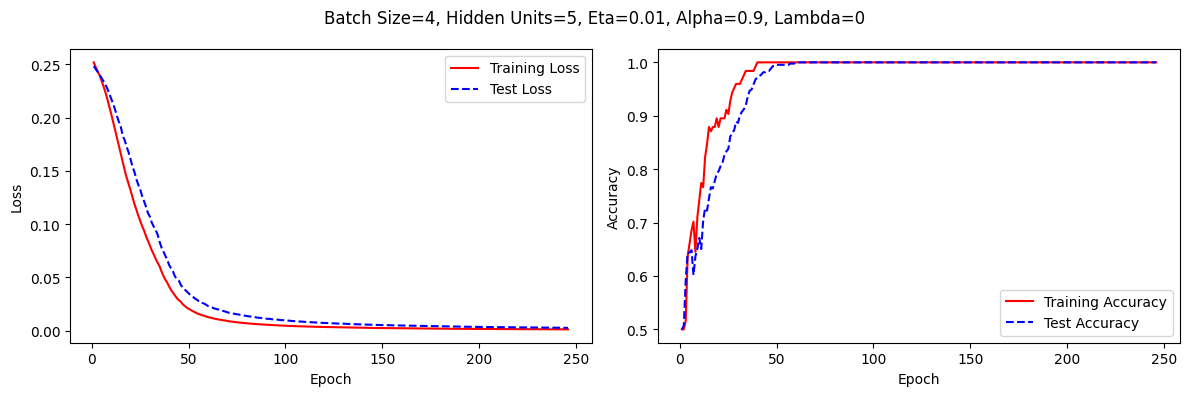

(246, 0.001161799649707973, 0.002609272487461567, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 2

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-2.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-2.test')

In [ ]:
hidden_sizes = [4]
learning_rates = [0.1]
momentums = [0.7]
batch_sizes = [4]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=4; lr=0.1; alpha = 0.7; batch size = 4; lambda = 0
Training - Epoch [162/1000], Loss: 0.0006, Accuracy: 1.0000 | Test - Epoch [162/1000], Loss: 0.0010 Accuracy: 1.0000 
 N. Epochs = 162 - Loss (train | test)= (0.000646 | 0.001011) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [146/1000], Loss: 0.0006, Accuracy: 1.0000 | Test - Epoch [146/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 146 - Loss (train | test)= (0.0005608 | 0.0005227) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [119/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [119/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 119 - Loss (train | test)= (0.0003936 | 0.0003813) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [103/1000], Loss: 0.0004, Accuracy: 1.0000 | Test - Epoch [103/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 103 - Loss (train | test)= (0.0003756 | 0.0005299) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [145/1000], Loss: 0.0006, Accuracy

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [363/1000], Loss: 0.0760, Accuracy: 0.9112 | Test - Epoch [363/1000], Loss: 0.1058 Accuracy: 0.8796 
 N. Epochs = 363 - Loss (train | test)= (0.07596 | 0.1058) - Accuracy (train | test) = (0.9112426035502958 | 0.8796296296296297)
Training - Epoch [180/1000], Loss: 0.0301, Accuracy: 0.9704 | Test - Epoch [180/1000], Loss: 0.0747 Accuracy: 0.9259 
 N. Epochs = 180 - Loss (train | test)= (0.03006 | 0.0747) - Accuracy (train | test) = (0.9704142011834319 | 0.9259259259259259)
Training - Epoch [136/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [136/1000], Loss: 0.0005 Accuracy: 1.0000 
 N. Epochs = 136 - Loss (train | test)= (0.000492 | 0.0005332) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [91/1000], Loss: 0.0003, Accuracy: 1.0000 | Test - Epoch [91/1000], Loss: 0.0003 Accuracy: 1.0000 
 N. Epochs = 91 - Loss (train | test)= (0.0002983 | 0.0003181) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [111/1000], Loss: 0.0004, Accuracy: 1.0000 | Test

Training - Epoch [104/1000], Loss: 0.0005, Accuracy: 1.0000 | Test - Epoch [104/1000], Loss: 0.0004 Accuracy: 1.0000 
 N. Epochs = 104 - Loss (train | test)= (0.0004544 | 0.0004226) - Accuracy (train | test) = (1.0 | 1.0)


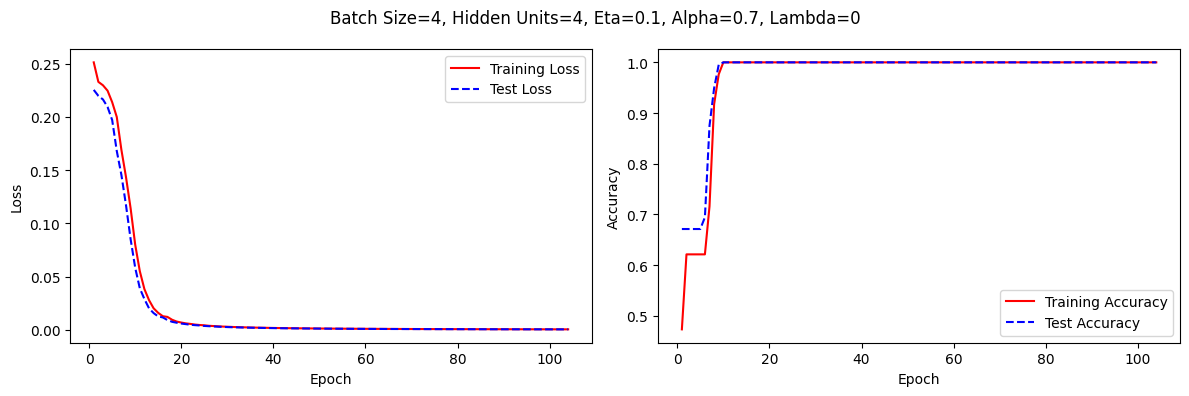

(104, 0.00045441946713253856, 0.0004225708544254303, 1.0, 1.0)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True)

# Monk 3 (no regularization)

In [ ]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

In [ ]:
hidden_sizes = [5]
learning_rates = [0.01,0.001]
momentums = [0.7,0.8]
batch_sizes = [4,16]
reg_coeffs = [0]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=False)

hidden_size=5; lr=0.01; alpha = 0.7; batch size = 4; lambda = 0
Training - Epoch [1000/1000], Loss: 0.0041, Accuracy: 1.0000 | Test - Epoch [1000/1000], Loss: 0.0154 Accuracy: 1.0000 
 N. Epochs = 1000 - Loss (train | test)= (0.004076 | 0.01536) - Accuracy (train | test) = (1.0 | 1.0)
Training - Epoch [1000/1000], Loss: 0.0143, Accuracy: 0.9897 | Test - Epoch [1000/1000], Loss: 0.1411 Accuracy: 0.8400 
 N. Epochs = 1000 - Loss (train | test)= (0.01432 | 0.1411) - Accuracy (train | test) = (0.9896907216494846 | 0.84)
Training - Epoch [1000/1000], Loss: 0.0220, Accuracy: 0.9694 | Test - Epoch [1000/1000], Loss: 0.0511 Accuracy: 0.9167 
 N. Epochs = 1000 - Loss (train | test)= (0.02197 | 0.05114) - Accuracy (train | test) = (0.9693877551020408 | 0.9166666666666666)
Training - Epoch [851/1000], Loss: 0.0021, Accuracy: 1.0000 | Test - Epoch [851/1000], Loss: 0.0969 Accuracy: 0.9167 
 N. Epochs = 851 - Loss (train | test)= (0.002057 | 0.09686) - Accuracy (train | test) = (1.0 | 0.91666666666

In [ ]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False)

Training - Epoch [1000/1000], Loss: 0.0727, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0586 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.07272 | 0.05857) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [1000/1000], Loss: 0.0703, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0567 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.07026 | 0.05672) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [1000/1000], Loss: 0.0626, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0464 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.06258 | 0.04645) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)
Training - Epoch [1000/1000], Loss: 0.0759, Accuracy: 0.9344 | Test - Epoch [1000/1000], Loss: 0.0587 Accuracy: 0.9722 
 N. Epochs = 1000 - Loss (train | test)= (0.07589 | 0.05865) - Accuracy (train | test) = (0.9344262295081968 | 0.97222222222222

Training - Epoch [1927/2000], Loss: 0.0624, Accuracy: 0.9344 | Test - Epoch [1927/2000], Loss: 0.0460 Accuracy: 0.9722 
 N. Epochs = 1927 - Loss (train | test)= (0.06238 | 0.04597) - Accuracy (train | test) = (0.9344262295081968 | 0.9722222222222222)


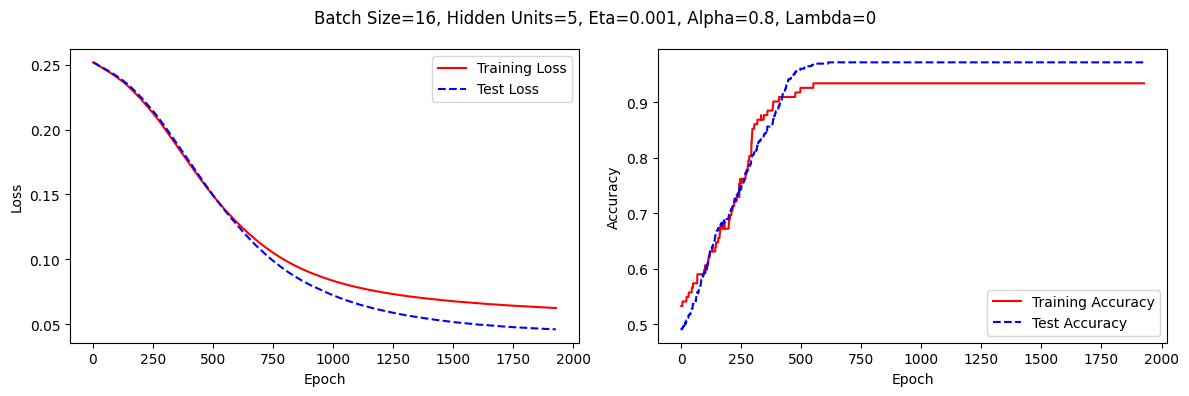

(1927,
 0.06238279864192009,
 0.04597325623035431,
 0.9344262295081968,
 0.9722222222222222)

In [ ]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=2000)

# Monk 3 (with regularization)

In [163]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-3.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-3.test')

hidden_size=5; lr=0.01; alpha = 0.8; batch size = 32; lambda = 0
Training - Epoch [2000/2000], Loss: 0.0213, Accuracy: 0.9897 | Test - Epoch [2000/2000], Loss: 0.0128 Accuracy: 1.0000 
 N. Epochs = 2000 - Loss (train | test)= (0.02129 | 0.01284) - Accuracy (train | test) = (0.9896907216494846 | 1.0)


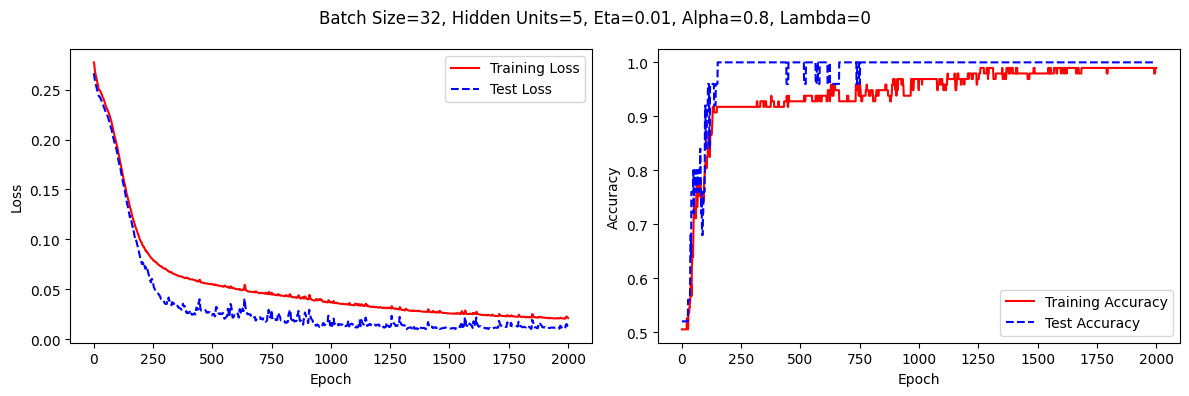

Training - Epoch [2000/2000], Loss: 0.0176, Accuracy: 0.9897 | Test - Epoch [2000/2000], Loss: 0.1508 Accuracy: 0.8000 
 N. Epochs = 2000 - Loss (train | test)= (0.01761 | 0.1508) - Accuracy (train | test) = (0.9896907216494846 | 0.8)


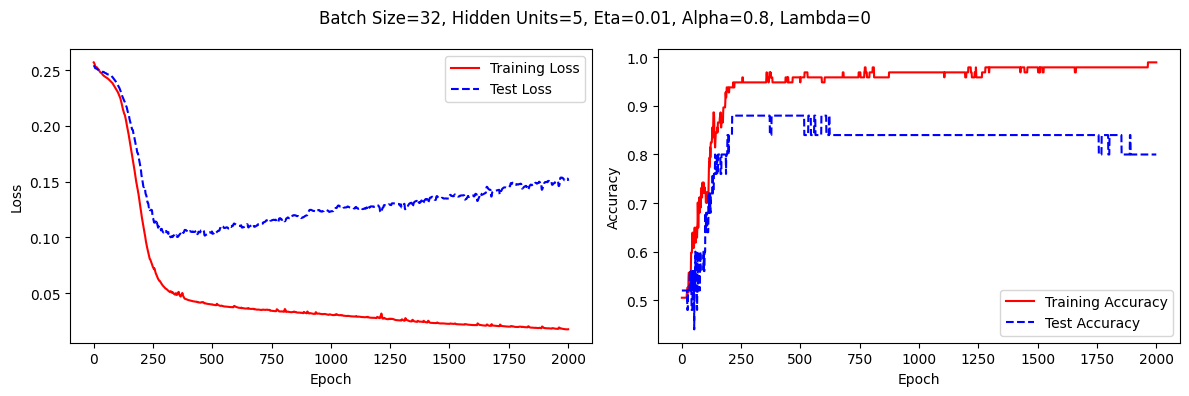

Training - Epoch [2000/2000], Loss: 0.0151, Accuracy: 0.9898 | Test - Epoch [2000/2000], Loss: 0.0288 Accuracy: 0.9583 
 N. Epochs = 2000 - Loss (train | test)= (0.01506 | 0.02879) - Accuracy (train | test) = (0.9897959183673469 | 0.9583333333333334)


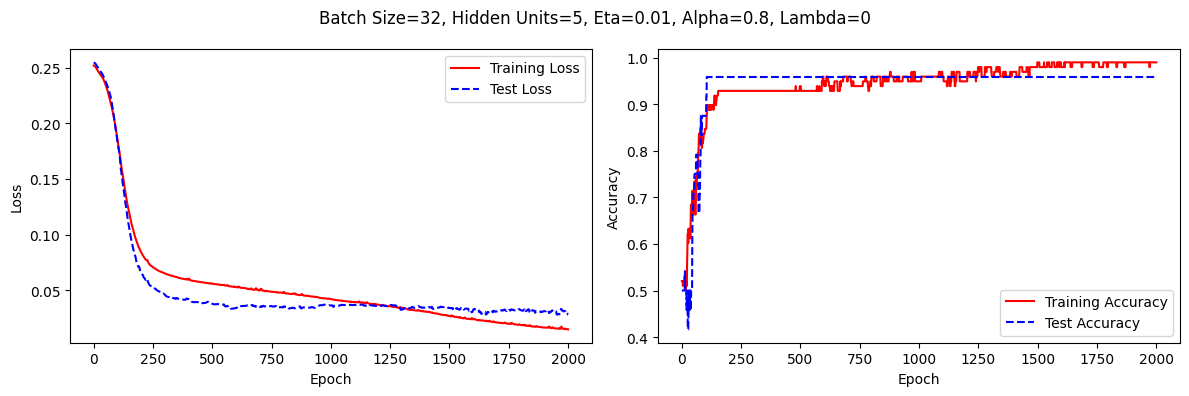

Training - Epoch [2000/2000], Loss: 0.0071, Accuracy: 1.0000 | Test - Epoch [2000/2000], Loss: 0.1125 Accuracy: 0.8333 
 N. Epochs = 2000 - Loss (train | test)= (0.00713 | 0.1125) - Accuracy (train | test) = (1.0 | 0.8333333333333334)


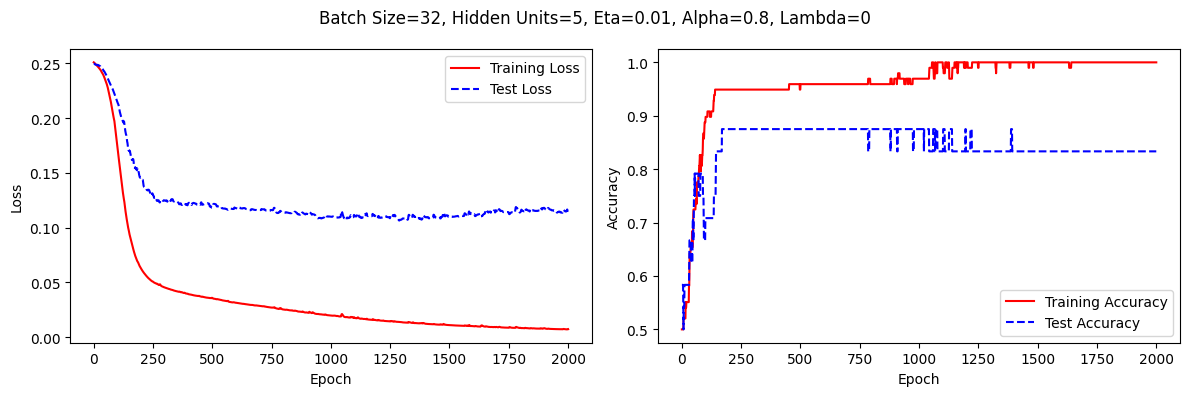

Training - Epoch [2000/2000], Loss: 0.0205, Accuracy: 0.9796 | Test - Epoch [2000/2000], Loss: 0.0541 Accuracy: 0.9583 
 N. Epochs = 2000 - Loss (train | test)= (0.02054 | 0.05411) - Accuracy (train | test) = (0.9795918367346939 | 0.9583333333333334)


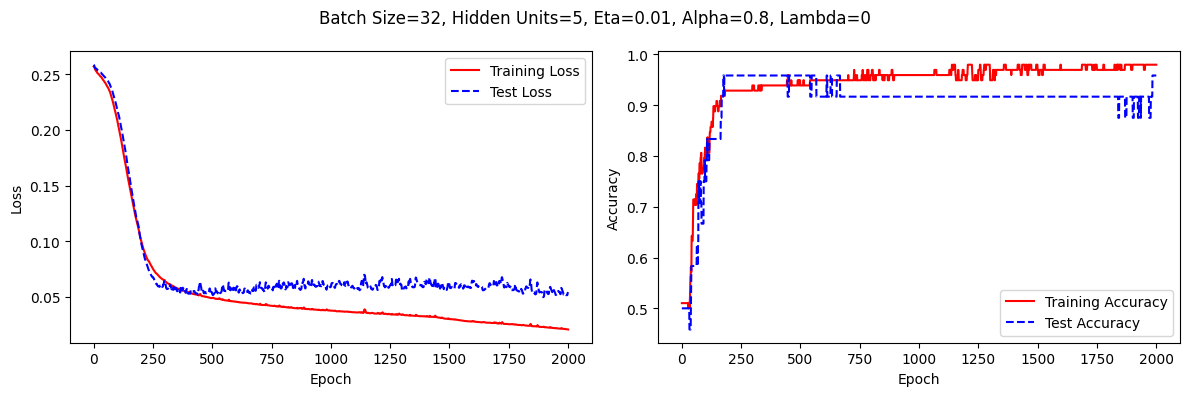

Final Results: hidden_size=5; lr=0.01; alpha = 0.8; batch size = 32; lambda = 0 --> train_loss = 0.01633 +- 0.005102 | val_loss = 0.0718 +- 0.05202train_acc = 0.9898 +- 0.006454 | val_acc = 0.91 +- 0.07842
hidden_size=5; lr=0.01; alpha = 0.8; batch size = 32; lambda = 0.001
Training - Epoch [2000/2000], Loss: 0.0243, Accuracy: 0.9897 | Test - Epoch [2000/2000], Loss: 0.0095 Accuracy: 1.0000 
 N. Epochs = 2000 - Loss (train | test)= (0.02434 | 0.009453) - Accuracy (train | test) = (0.9896907216494846 | 1.0)


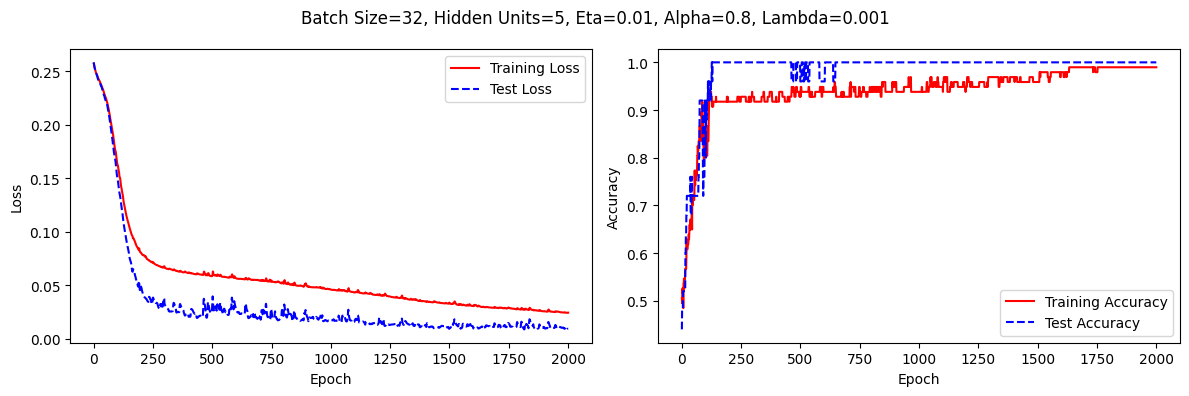

Training - Epoch [2000/2000], Loss: 0.0245, Accuracy: 0.9794 | Test - Epoch [2000/2000], Loss: 0.1256 Accuracy: 0.8400 
 N. Epochs = 2000 - Loss (train | test)= (0.02447 | 0.1256) - Accuracy (train | test) = (0.979381443298969 | 0.84)


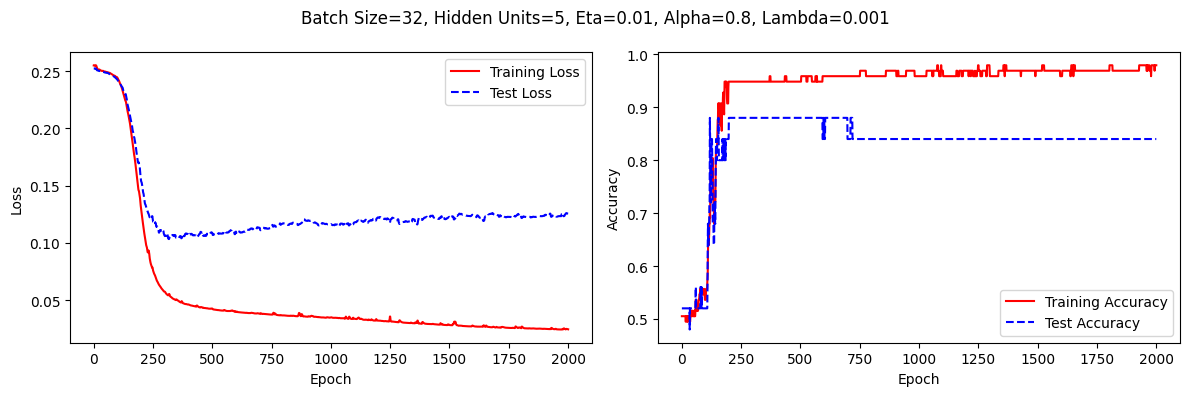

Training - Epoch [2000/2000], Loss: 0.0270, Accuracy: 0.9796 | Test - Epoch [2000/2000], Loss: 0.0343 Accuracy: 0.9583 
 N. Epochs = 2000 - Loss (train | test)= (0.027 | 0.03432) - Accuracy (train | test) = (0.9795918367346939 | 0.9583333333333334)


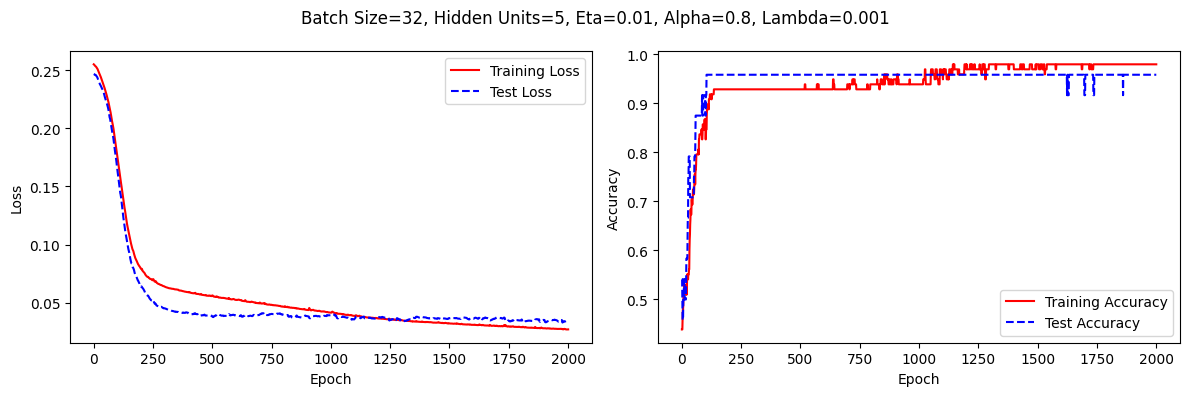

Training - Epoch [2000/2000], Loss: 0.0124, Accuracy: 1.0000 | Test - Epoch [2000/2000], Loss: 0.1045 Accuracy: 0.9167 
 N. Epochs = 2000 - Loss (train | test)= (0.01242 | 0.1045) - Accuracy (train | test) = (1.0 | 0.9166666666666666)


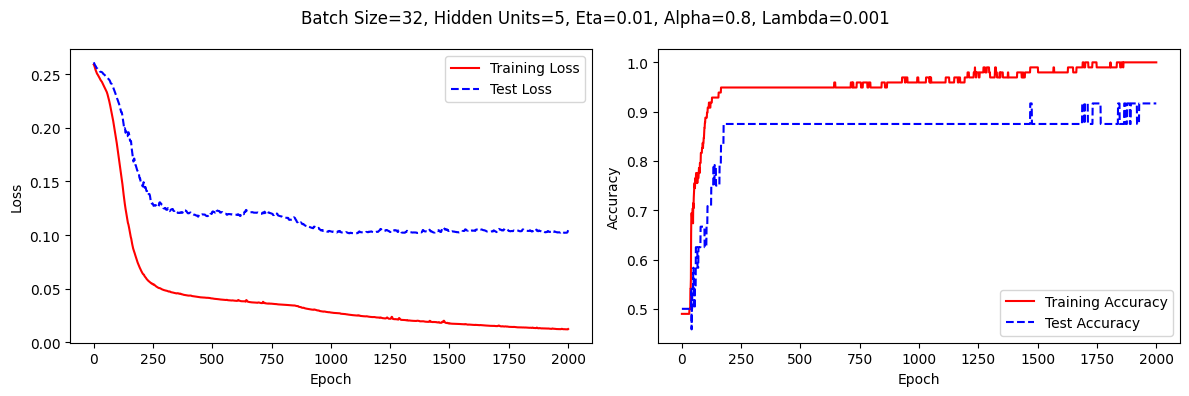

Training - Epoch [2000/2000], Loss: 0.0375, Accuracy: 0.9592 | Test - Epoch [2000/2000], Loss: 0.0690 Accuracy: 0.9167 
 N. Epochs = 2000 - Loss (train | test)= (0.03746 | 0.06901) - Accuracy (train | test) = (0.9591836734693877 | 0.9166666666666666)


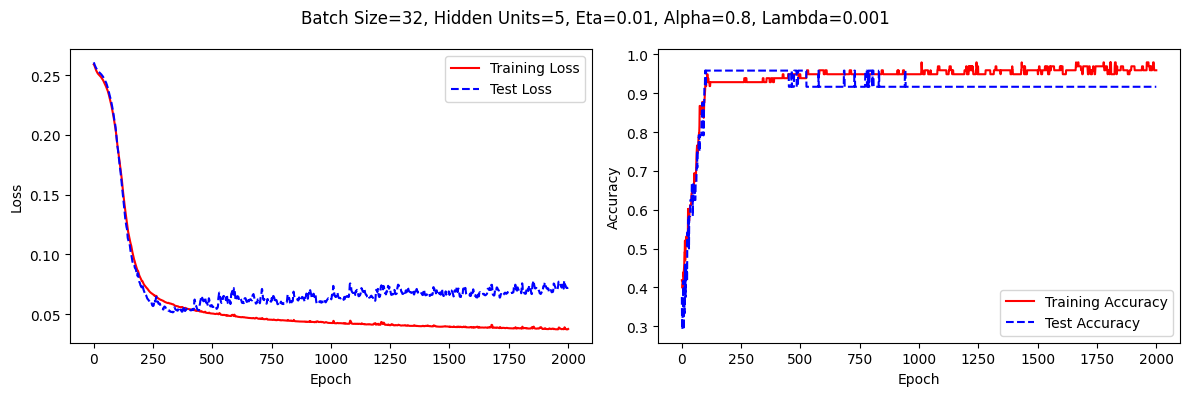

Final Results: hidden_size=5; lr=0.01; alpha = 0.8; batch size = 32; lambda = 0.001 --> train_loss = 0.02514 +- 0.007979 | val_loss = 0.06858 +- 0.04293train_acc = 0.9816 +- 0.01353 | val_acc = 0.9263 +- 0.05309
[5, 0.01, 0.8, 32, 0.001]


In [168]:
hidden_sizes = [5]
learning_rates = [0.01]
momentums = [0.8]
batch_sizes = [32]
reg_coeffs = [0,1e-3]


best_hp = perform_grid_search_kfold(hidden_sizes,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    k_folds=5,
                                    x=x_train,
                                    y=y_train,
                                    plot_curves=True,
                                    num_epochs=2000)

In [169]:
train_with_different_initializations(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=False,
               num_epochs=3000)

Training - Epoch [896/3000], Loss: 0.0482, Accuracy: 0.9426 | Test - Epoch [896/3000], Loss: 0.0445 Accuracy: 0.9606 
 N. Epochs = 896 - Loss (train | test)= (0.04824 | 0.04448) - Accuracy (train | test) = (0.9426229508196722 | 0.9606481481481481)
Training - Epoch [1218/3000], Loss: 0.0449, Accuracy: 0.9508 | Test - Epoch [1218/3000], Loss: 0.0435 Accuracy: 0.9560 
 N. Epochs = 1218 - Loss (train | test)= (0.04492 | 0.04348) - Accuracy (train | test) = (0.9508196721311475 | 0.9560185185185185)
Training - Epoch [1118/3000], Loss: 0.0460, Accuracy: 0.9426 | Test - Epoch [1118/3000], Loss: 0.0437 Accuracy: 0.9606 
 N. Epochs = 1118 - Loss (train | test)= (0.04605 | 0.04367) - Accuracy (train | test) = (0.9426229508196722 | 0.9606481481481481)
Training - Epoch [3000/3000], Loss: 0.0234, Accuracy: 0.9836 | Test - Epoch [3000/3000], Loss: 0.0306 Accuracy: 0.9653 
 N. Epochs = 3000 - Loss (train | test)= (0.02337 | 0.03063) - Accuracy (train | test) = (0.9836065573770492 | 0.9652777777777778)

Training - Epoch [2067/3000], Loss: 0.0287, Accuracy: 0.9754 | Test - Epoch [2067/3000], Loss: 0.0271 Accuracy: 0.9699 
 N. Epochs = 2067 - Loss (train | test)= (0.02874 | 0.02715) - Accuracy (train | test) = (0.9754098360655737 | 0.9699074074074074)


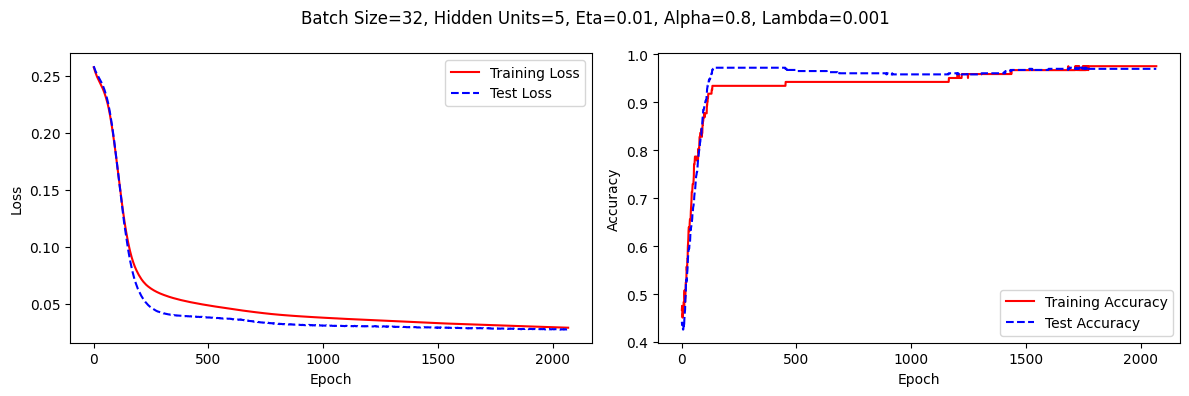

(2067,
 0.02874196507036686,
 0.027146896347403526,
 0.9754098360655737,
 0.9699074074074074)

In [170]:
# train the model on all the test set using the best hyperparameters found

training_model(x_train=x_train,
               y_train=y_train,
               x_test=x_test,
               y_test=y_test,
               hidden_size=best_hp[0],
               learning_rate=best_hp[1],
               momentum=best_hp[2],
               bs = best_hp[3],
               reg_coeff= best_hp[4],
               plot_curves=True,
               num_epochs=3000)